<a href="https://colab.research.google.com/github/OJO44/24bMachineLearning1/blob/main/BengaluruHousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import the necessary python librarires

In [68]:
#for data cleaning
import pandas as pd
import numpy as np
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
#for feature engineering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#for machine learning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 2.Load the dataset

In [69]:
data= "/content/Bengaluru_House_Data.csv"
df1= pd.read_csv(data)


# 3.EDA

In [70]:
df1.head(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [71]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [72]:
df1.shape

(13320, 9)

In [73]:
# Group the 'bengaluru' DataFrame by the 'area_type' column
# and count the number of rows for each unique 'area_type' value
area_type_counts = df1.groupby("area_type")["area_type"].agg("count")

# The resulting Series will have the 'area_type' as the index
# and the count of each 'area_type' as the values
print(area_type_counts)



area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64


In [74]:
# Drop the 'area_type', 'availability', 'soceity', and 'balcony' columns
# from the 'bengaluru' DataFrame as they may not be important
# for predicting housing prices
df2 = df1.drop(["area_type", "availability", "society", "balcony"], axis=1)

# Display the updated 'bengaluru2' DataFrame
df2.head()


,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


# 4.Data Cleaning

In [75]:
df2.isnull().sum()
# we could decide to do away with some which have a certain percent of missing values
# let us get this percentages
total_missing=df2.isnull().sum().sort_values(ascending=False)
percent=df2.isnull().sum().sort_values(ascending=False)/df2.isnull().count().sort_values(ascending=False)
missing_df=pd.concat([total_missing,percent],axis=1,keys=['total_missing','percentage_missing'],sort=False)
missing_df.index.name='variable'# set the index name to variable
missing_df=missing_df[total_missing>0] # only retain those with missing values
missing_df['percentage_missing']=missing_df['percentage_missing'].map(lambda x:x*100) # convert to percentage
missing_df

,total_missing,percentage_missing
variable,,
bath,73,0.548048
size,16,0.120120
location,1,0.007508


In [76]:
# Fill the missing values in the 'bath' column of the 'df2' DataFrame
# with the median value of the 'bath' column
df2['bath'] = df2['bath'].fillna(df2['bath'].median())

# Drop any rows from 'df2' that have missing values in the 'size' or 'location' columns
df2 = df2.dropna(subset=['size', 'location'])

# Print the count of missing values in each column of the 'df2' DataFrame
print(df2.isnull().sum())



location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64


In [77]:
df2.shape

(13303, 5)

In [11]:
df2["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [78]:
#create a new column called bhk
df2["bhk"]= df2["size"].apply(lambda x: int(x.split(" ")[0]))

In [79]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [80]:
df2["bhk"].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [81]:
df2[df2.bhk >20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [82]:
#explore the total_sqft column
df2["total_sqft"].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

some values are in range instead of single values

In [83]:
#
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True


df2[df2["total_sqft"].apply(is_float)]
df2[~df2["total_sqft"].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
224,Devanahalli,3 BHK,1520 - 1740,2.0,74.820,3
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2


In [84]:
#Handling non uniformities in values under total sqft
def convert_total_sqft_to_num(x):
  token = x.split("-")
  if len(token) ==2:
    return (float(token[0])+float(token[1]))/2
  try:
     return float (x)
  except:
     return None

In [85]:
convert_total_sqft_to_num("34.46Sq. Meter	")

In [86]:
df3 = df2.copy()
df3["total_sqft"] = df3 ["total_sqft"].apply(convert_total_sqft_to_num)
df3.head(10)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
5,Whitefield,2 BHK,1170.0,2.0,38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,370.00,6


In [87]:
df3.loc[122]

location      Hebbal
size           4 BHK
total_sqft    5611.5
bath             4.0
price          477.0
bhk                4
Name: 122, dtype: object

# 5.Applying feature engineering techniques


In [88]:
df4= df3.copy()
#in real estate, price per sqft is very important
df4["price_per_sqft"]= df4["price"]*100000/df4["total_sqft"]
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [89]:
#Lets check on my categorical variable locaton
len(df4.location.unique())

1304

the locations are too many which can lead us to a problem called dimentionality curse.

In [90]:
#Its time to reduce  the dimentions
#Confirm how many data points are in our locations
df4.location = df4.location.apply(lambda x : x.strip())

location_stat = df4.groupby("location")["location"].agg("count").sort_values(ascending = False)
location_stat

location
Whitefield               540
Sarjapur  Road           397
Electronic City          304
Kanakpura Road           273
Thanisandra              237
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [91]:
#lets confirm how many locations have less than 10 data point
location_stat_less_10 = len(location_stat[location_stat<=10])

In [92]:
# Get the locations with less than 10 samples
location_stat_less_10 = location_stat[location_stat <= 10].index.tolist()

# Replace the location value with "other" if the location is in the set of locations with less than 10 samples
df4['location'] = df4['location'].apply(lambda x: "other" if x in location_stat_less_10 else x)
len(df4.location.unique())



242

# 6.Outlier detections and removal

In [93]:
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [94]:
#to handle outliers, it requires domain knowledge or you can use standard deviation.
df4[df4.total_sqft/df4.bhk <300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [95]:
#df5 = df4[df4~(df4.total_sqft/df4.bhk <300)]
# Calculate the ratio of 'total_sqft' to 'bhk' for each row in the 'df4' DataFrame
sqft_per_bhk = df4['total_sqft'] / df4['bhk']

# Create a boolean mask where the 'sqft_per_bhk' is less than 300
mask = sqft_per_bhk >= 300

# Create a new DataFrame 'df5' by selecting the rows where the 'mask' is True
df5 = df4[mask]
df5.shape


(12513, 7)

In [96]:
df5.price_per_sqft.describe()

count     12513.000000
mean       6307.441644
std        4160.931610
min         267.829813
25%        4210.526316
50%        5295.007564
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [97]:
df5.bath.unique()

array([ 2.,  5.,  3.,  4.,  1.,  8.,  6.,  7.,  9., 14., 12., 16., 10.,
       13.])

In [98]:
df5[df5.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1078,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
3096,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
3609,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
7979,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
8636,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
9935,other,13 BHK,5425.0,13.0,275.0,13,5069.124424
13067,other,10 Bedroom,7150.0,13.0,3600.0,10,50349.650350


Text(0, 0.5, 'Count')

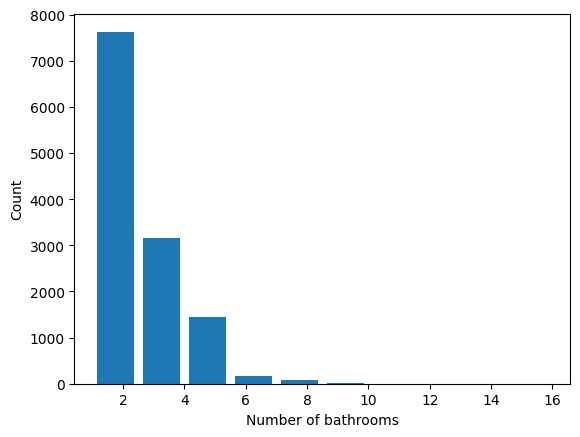

In [99]:
plt.hist(df5.bath, rwidth = 0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [100]:
df5.drop(["size", "price_per_sqft"], axis = 1)

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5
13316,other,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4689.0,4.0,488.00,4


# 7.Encoding

In [101]:
dummies = pd.get_dummies(df5.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [103]:
df6 = pd.concat([df5, dummies.drop("other", axis=1)], axis=1)



In [52]:
df6.head()



,location,size,total_sqft,bath,price,bhk,price_per_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [108]:
df6.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12513 entries, 0 to 13319
Columns: 248 entries, location to Yeshwanthpur
dtypes: bool(241), float64(4), int64(1), object(2)
memory usage: 3.6+ MB


In [109]:
# Get the columns with object data type
object_cols = df6.select_dtypes(include='object').columns

# Drop the columns with object data type
df7 = df6.drop(object_cols, axis=1)


In [110]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12513 entries, 0 to 13319
Columns: 246 entries, total_sqft to Yeshwanthpur
dtypes: bool(241), float64(4), int64(1)
memory usage: 3.4 MB


In [112]:
df7.shape

(12513, 246)

# 8.Machine Learning Models

In [114]:
X= df7.drop("price", axis= 1)
X.head(3)
y= df7.price

In [115]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test= train_test_split(X,y, test_size= 0.2,random_state=10)


In [116]:
#Try  linear LinearRegression
from sklearn.linear_model import LinearRegression
ln_model = LinearRegression()
ln_model.fit(X_train, y_train)
ln_score = ln_model.score(X_test, y_test)
print("Linear Regression score:", ln_score)

Linear Regression score: 0.7548522245947776


In [ ]:
## Perform 5-fold cross-validation on the LinearRegression model
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=5)
scores = cross_val_score(LinearRegression(), X, y, cv=cv)

print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean():.2f}")


In [131]:
# Try Lasso Regression
from sklearn.linear_model import Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_score = lasso_model.score(X_test, y_test)
print("Lasso Regression score:", lasso_score)


Lasso Regression score: 0.7504571410846779


In [132]:
# Try Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_score = rf_model.score(X_test, y_test)
print("Random Forest Regression score:", rf_score)


Random Forest Regression score: 0.9709272799451693


It seems random forest regression model gives the best prediction.

# 9.Hyperparameter Tuning

In [130]:
#use grid search cv to assist in getting the best model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_GridSearchCV(X, y):
    try:
        # Define the models and their hyperparameters to search over
        models = {
            "Lasso": Lasso(),
            "DecisionTreeRegressor": DecisionTreeRegressor()
        }

        param_grids = {
            "Lasso": {"alpha": [0.1, 1.0, 10.0]},
            "DecisionTreeRegressor": {"max_depth": [3, 5, 7], "min_samples_split": [2, 5, 10]}
        }

        # Create the grid search object
        grid = GridSearchCV(estimator=models, param_grid=param_grids, cv=5, scoring="r2", verbose=0)

        # Fit the grid search
        grid.fit(X, y)

        # Get the best model and its parameters
        best_model = grid.best_estimator_
        best_params = grid.best_params_

        return best_model, best_params
    except Exception as e:
        print(f"Error occurred: {e}")
        return None, None
find_best_model_using_GridSearchCV(X, y)
#best_model, best_params = find_best_model_using_GridSearchCV(X, y)
#if best_model is not None and best_params is not None:
 #   print("Best Model:", best_model)
 #   print("Best Parameters:", best_params)
#else:
  #  print("Failed to find the best model.")




Error occurred: estimator should be an estimator implementing 'fit' method, {'Lasso': Lasso(), 'DecisionTreeRegressor': DecisionTreeRegressor()} was passed


(None, None)

In [128]:
#How about a random search cv
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import uniform, randint

def find_best_model_using_RandomizedSearchCV(X, y):
    try:
        # Define the models and their hyperparameter distributions
        models = {
            "Lasso": Lasso(),
            "DecisionTreeRegressor": DecisionTreeRegressor()
        }

        param_distributions = {
            "Lasso": {"alpha": uniform(0.1, 10.0)},
            "DecisionTreeRegressor": {"max_depth": randint(3, 8), "min_samples_split": randint(2, 11)}
        }

        # Create the randomized search object
        random_search = RandomizedSearchCV(estimator=models, param_distributions=param_distributions, n_iter=20, cv=5, scoring="r2", random_state=42, verbose=0)

        # Fit the randomized search
        random_search.fit(X, y)

        # Get the best model and its parameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        return best_model, best_params
    except Exception as e:
        print(f"Error occurred: {e}")
        return None, None

best_model, best_params = find_best_model_using_RandomizedSearchCV(X, y)
if best_model is not None and best_params is not None:
    print("Best Model:", best_model)
    print("Best Parameters:", best_params)
else:
    print("Failed to find the best model.")


Error occurred: estimator should be an estimator implementing 'fit' method, {'Lasso': Lasso(), 'DecisionTreeRegressor': DecisionTreeRegressor()} was passed
Failed to find the best model.
